In [0]:
dbutils.library.installPyPI('FBProphet', version='0.5') # find latest version of fbprophet here: https://pypi.org/project/fbprophet/
dbutils.library.installPyPI('plotly')
dbutils.library.installPyPI('holidays','0.9.12') # this line is in response to this issue with fbprophet 0.5: https://github.com/facebook/prophet/issues/1293
dbutils.library.restartPython()

In [0]:
from pyspark.sql.functions import col, lit, sum, count, year, month, dayofmonth, desc, last_day, to_timestamp, to_date, unix_timestamp
from pyspark.sql.types import *
from datetime import datetime, timedelta
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import logging
logger = spark._jvm.org.apache.log4j
logging.getLogger("py4j").setLevel(logging.ERROR)
from fbprophet import Prophet

REF_DATE = datetime.strptime('04/11/2020', '%d/%m/%Y')

In [0]:
Ref_Geo = spark.read.format("delta").load("/mnt/kbi/KBI_NG/PROD/tmp/Ref_Geo")

In [0]:
Daily_Sales = spark.read.format("delta").load("/mnt/kbi/KBI_NG/PROD/tmp/Daily_Sales")\
  .join(Ref_Geo, on='COUNTRY_CODE', how='left')\
  .groupby("DT_BORD_REF", "CAI_MARKET_FDM_SK", "COUNTRY_ALPHA").agg(sum('QUANTITY').alias('QUANTITY'))\
  .select("COUNTRY_ALPHA", "CAI_MARKET_FDM_SK", col("DT_BORD_REF").alias("ds"), col("QUANTITY").alias("y"))\

In [0]:
# Daily_Sales.printSchema()
# print(Daily_Sales.agg({'ds': "max"}).collect()[0][0])

In [0]:
# Set a country as referencial and split train/test datasets for the model

Country = 'JP'

#only consider more than 150 observations
X_train = Daily_Sales\
  .filter(col("COUNTRY_ALPHA")==Country)\
  .filter(col("DT_BORD_REF") < REF_DATE)\
  .withColumn("concat", F.concat("COUNTRY_ALPHA", "CAI_MARKET_FDM_SK"))\
  .withColumn("count", count("concat").over(Window.partitionBy("concat")).alias("count"))\
  .filter(col("count")>150)\
  .repartition(sc.defaultParallelism, ['COUNTRY_ALPHA', 'CAI_MARKET_FDM_SK'])\
  .cache()

X_val = Daily_Sales\
  .filter(col("COUNTRY_ALPHA")==Country)\
  .filter(col("DT_BORD_REF") >= REF_DATE)\
  .filter(month("DT_BORD_REF") == REF_DATE.month)\
  .filter(year("DT_BORD_REF") == REF_DATE.year)\

In [0]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('COUNTRY_ALPHA',StringType()),
  StructField('CAI_MARKET_FDM_SK',StringType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

In [0]:
#using a panda_udf functionality with a group by to create a model for each product

from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_DS( history_pd ):
  
  history_pd = history_pd.dropna()
  
  # configure the model
  model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative')
  
  #model.add_country_holidays(country_name=history_pd['COUNTRY_ALPHA'].iloc[0])
  
  # train the model
  model.fit( history_pd )

  future_pd = model.make_future_dataframe(
    periods=30, 
    freq='d', 
    include_history=True
    )
  forecast_pd = model.predict( future_pd )  

  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  h_pd = history_pd[['ds','COUNTRY_ALPHA', 'CAI_MARKET_FDM_SK','y']].set_index('ds')
  
  # join history and forecast
  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  # get country & product from incoming data set
  results_pd['COUNTRY_ALPHA'] = history_pd['COUNTRY_ALPHA'].iloc[0]
  results_pd['CAI_MARKET_FDM_SK'] = history_pd['CAI_MARKET_FDM_SK'].iloc[0]
  # --------------------------------------
  
  # return expected dataset
  return results_pd[ ['ds', 'COUNTRY_ALPHA', 'CAI_MARKET_FDM_SK', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

In [0]:
# from pyspark.sql.functions import current_date

results = X_train\
  .groupBy('COUNTRY_ALPHA', 'CAI_MARKET_FDM_SK')\
  .apply(forecast_DS)\
  .select("COUNTRY_ALPHA", "CAI_MARKET_FDM_SK", "ds", "yhat")\

#   .write.format("delta").mode("overwrite").partitionBy("ds").save("/mnt/kbi/KBI_NG/PROD/tmp/Daily_Sales_Forecast")\
# display(spark.sql("DROP TABLE  IF EXISTS Daily_Sales_Forecast"))
# display(spark.sql("CREATE TABLE Daily_Sales_Forecast USING DELTA LOCATION '/mnt/kbi/KBI_NG/PROD/tmp/Daily_Sales_Forecast'"))
# display(spark.sql("OPTIMIZE Daily_Sales_Forecast ZORDER BY (CAI_MARKET_FDM_SK)"))


In [0]:
#Join predictions and validation set
df = X_val\
  .join(results.select('ds', 'COUNTRY_ALPHA', 'CAI_MARKET_FDM_SK', 'yhat'), on=["COUNTRY_ALPHA", "CAI_MARKET_FDM_SK", "ds"], how='full')\
  .filter(col("ds") >= REF_DATE)\
  .filter(month("ds") == REF_DATE.month)\
  .filter(year("ds") == REF_DATE.year)\

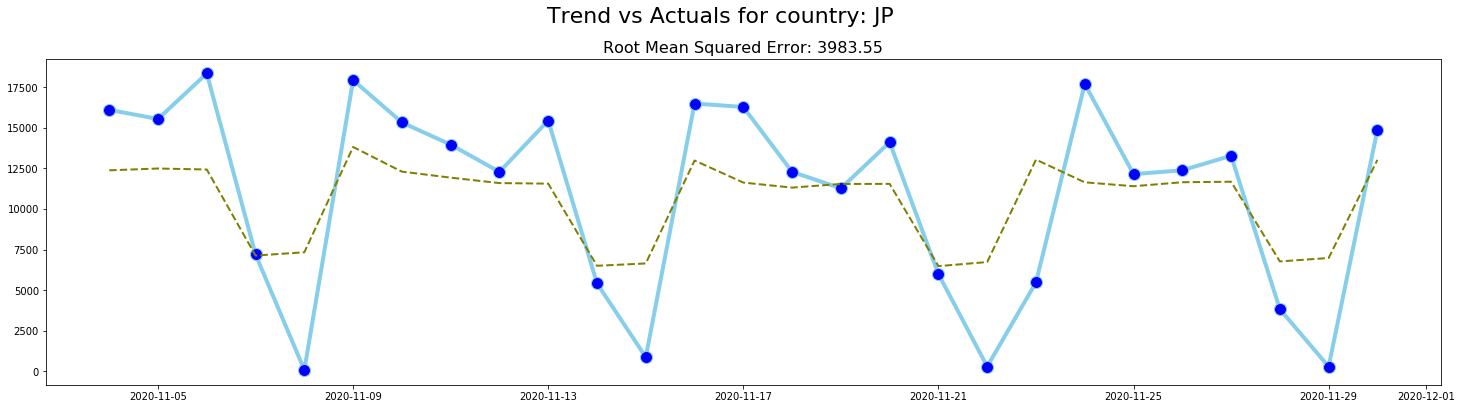

In [0]:
#Plot forecast and actual to visualize the fit with RMSE

df = df\
  .filter(month("ds") == REF_DATE.month)\
  .filter(year("ds") == REF_DATE.year)\
  .filter(dayofmonth("ds") >= REF_DATE.day)\
  .filter(col("COUNTRY_ALPHA")==Country)\
  .groupBy("ds").sum("y","yhat")\
  .na.fill(0)\
  .select("ds", col("sum(y)").alias("QUANTITY"),col("sum(yhat)").alias("QTE_PREV"))\
  .sort("ds")

rmse = df\
  .withColumn('difference', F.col('QUANTITY') - F.col('QTE_PREV'))\
  .withColumn('squared_difference', F.pow(F.col('difference'), F.lit(2).astype(IntegerType())))\
  .select(F.sqrt(F.avg(F.col('squared_difference'))).alias('rmse'))\
  .collect()[0][0]

df = df.toPandas()

plt.rcParams["figure.figsize"] = [25,6]

fig2 = plt.plot('ds', 'QUANTITY', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
fig2 = plt.plot('ds', 'QTE_PREV', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')
fig2 = plt.suptitle('Trend vs Actuals for country: ' + Country, fontsize=22, x=0.5, y=1)
fig2 = plt.title('Root Mean Squared Error: '+str(round(rmse,2)), fontsize=16)

display()